<a href="https://colab.research.google.com/github/Mukiti-Ryan/IS_Project_Presentation/blob/main/Churn_Model_(Work_RC%2C_RFC%2C_GSCV).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## In this case, I will use RidgeClassifier, RandomForestClassifier and GridSearchCV.

I will also use the following methods of binning and outline the pros and cons of both of them in this particular task.

1. Equal - Width Binning
2. Equal - Frequency Binning

Let's first install the required libraries:

In [ ]:
!pip install -U imbalanced-learn -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 KB 8.5 MB/s eta 0:00:00


Let's load the dataset and check the shape:

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/IS Project 2 Datasets/churnmodel.csv')
df.shape

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(1000000, 16)

Let's view the dataset to identify the target variable: (In this case, I am building a customer churn prediction model, hence, my target variable will be **STATUS2**

In [ ]:
df.head()

,Unnamed: 0,CD_ACCOUNT,STATUS2,DAYS_ACC_OPEN,CD_TYPE,VL_CREDIT_RECENCY,VL_DEBIT_RECENCY,VL_TENOR,AVGCREDITTURNOVER_LY,AVGDEBITTURNOVER_LY,AVGCREDIT_TRANS_LY,AVGDEBIT_TRANS_LY,AVGCREDITTURNOVER_LY2,AVGDEBITTURNOVER_LY2,AVGCREDIT_TRANS_LY2,AVGDEBIT_TRANS_LY2
0,0,1100000000000.0,NOT CHURNED,6173,1062,21.0,0.0,6170.0,438197.26,-474788.26,3.08,93.66,720779.28,-748023.72,6.33,133.41
1,1,1100000000000.0,CHURNED,6163,1062,313.0,0.0,6118.0,1666.66,-6590.41,0.16,1.25,1666.66,-9322.83,0.16,3.08
2,2,1100000000000.0,CHURNED,6152,1062,2126.0,1949.0,6132.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,3,1100000000000.0,CHURNED,6124,1062,982.0,0.0,5770.0,0.00,-1220.00,0.00,0.41,0.00,-2102.00,0.00,0.91
4,4,1100000000000.0,NOT CHURNED,6117,1062,0.0,0.0,6091.0,4126.41,-200.50,1.08,3.66,7935.41,-395.00,2.08,7.50


# **1. Clean the Dataset**
---


Let's check the datatypes of the columns available in the dataset:

In [ ]:
print(df.dtypes)

Unnamed: 0                 int64
CD_ACCOUNT                object
STATUS2                   object
DAYS_ACC_OPEN              int64
CD_TYPE                    int64
VL_CREDIT_RECENCY        float64
VL_DEBIT_RECENCY         float64
VL_TENOR                 float64
AVGCREDITTURNOVER_LY     float64
AVGDEBITTURNOVER_LY      float64
AVGCREDIT_TRANS_LY       float64
AVGDEBIT_TRANS_LY        float64
AVGCREDITTURNOVER_LY2    float64
AVGDEBITTURNOVER_LY2     float64
AVGCREDIT_TRANS_LY2      float64
AVGDEBIT_TRANS_LY2       float64
dtype: object


Let's rename the unnamed column:

In [ ]:
if 'Unnamed: 0' in df.columns:
  df = df.drop(columns = ['Unnamed: 0'])

The data set we are using is already clean but let's just check to be sure:

In [ ]:
df.isna().sum().sum()

0

In [ ]:
neg_counts = (df.select_dtypes(include = np.number) < 0).sum()

if neg_counts.any():
  print("Columns with negative values: ")
  print(neg_counts[neg_counts != 0])

  print(f"Total number of negative values: {neg_counts.sum()}")
else:
  print("There are no negative values in the dataset")

Columns with negative values: 
VL_CREDIT_RECENCY          1136
VL_DEBIT_RECENCY             98
VL_TENOR                  10212
AVGCREDITTURNOVER_LY         22
AVGDEBITTURNOVER_LY      746136
AVGCREDIT_TRANS_LY            6
AVGCREDITTURNOVER_LY2        17
AVGDEBITTURNOVER_LY2     792223
AVGCREDIT_TRANS_LY2           5
dtype: int64
Total number of negative values: 1549855


In [ ]:
numeric_cols = df.select_dtypes(include = [int, float]).columns
df[numeric_cols] = df[numeric_cols].abs()

In [ ]:
stats = df.describe()

print(stats.loc[['min', 'max']])

     DAYS_ACC_OPEN  CD_TYPE  VL_CREDIT_RECENCY  VL_DEBIT_RECENCY  VL_TENOR  \
min           20.0   1062.0                0.0               0.0       0.0   
max        44655.0   1063.0            19406.0           19407.0   44653.0   

     AVGCREDITTURNOVER_LY  AVGDEBITTURNOVER_LY  AVGCREDIT_TRANS_LY  \
min          0.000000e+00         0.000000e+00                0.00   
max          6.375964e+09         6.375980e+09            25433.25   

     AVGDEBIT_TRANS_LY  AVGCREDITTURNOVER_LY2  AVGDEBITTURNOVER_LY2  \
min               0.00           0.000000e+00          0.000000e+00   
max           12109.33           9.306696e+10          9.306696e+10   

     AVGCREDIT_TRANS_LY2  AVGDEBIT_TRANS_LY2  
min                 0.00                0.00  
max             47800.66            15476.66  


In [ ]:
df.describe()

,DAYS_ACC_OPEN,CD_TYPE,VL_CREDIT_RECENCY,VL_DEBIT_RECENCY,VL_TENOR,AVGCREDITTURNOVER_LY,AVGDEBITTURNOVER_LY,AVGCREDIT_TRANS_LY,AVGDEBIT_TRANS_LY,AVGCREDITTURNOVER_LY2,AVGDEBITTURNOVER_LY2,AVGCREDIT_TRANS_LY2,AVGDEBIT_TRANS_LY2
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1.000000e+06,1.000000e+06,1000000.000000,1000000.000000,1.000000e+06,1.000000e+06,1000000.000000,1000000.000000
mean,2284.078102,1062.066047,1253.549290,1979.869468,2382.946083,6.199433e+04,6.279789e+04,2.469595,4.593288,2.075195e+05,2.086299e+05,4.622182,8.833637
std,1737.424068,0.248364,4144.024187,5478.787502,2439.527684,8.613043e+06,8.593854e+06,49.061543,17.684722,9.422977e+07,9.423014e+07,90.504225,29.221068
min,20.000000,1062.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,762.000000,1062.000000,0.000000,0.000000,721.000000,0.000000e+00,0.000000e+00,0.000000,0.080000,2.080000e+00,3.100000e-01,0.080000,0.250000
50%,1972.000000,1062.000000,26.000000,0.000000,1862.000000,2.416600e+02,1.625000e+02,0.330000,0.580000,1.532080e+03,1.333330e+03,0.580000,1.160000
75%,3461.000000,1062.000000,392.000000,378.000000,3456.000000,9.986177e+03,1.022263e+04,0.910000,3.910000,2.098320e+04,2.114132e+04,1.660000,7.410000
max,44655.000000,1063.000000,19406.000000,19407.000000,44653.000000,6.375964e+09,6.375980e+09,25433.250000,12109.330000,9.306696e+10,9.306696e+10,47800.660000,15476.660000


Binary Value Columns are columns which carry values that can be mapped to the binary values 0 and 1. *For example, Churned = 1 and Not Churned = 0*

Multiple Values Columns are columns which carry values that can be categorised into several groups. *For example, Education_Level can be grouped into High School, College, Graduate, Post-Graduate and Doctorate*.

Let's divide the columns into discrete features (binary value columns, multiple value columns) and continuous features:

In [ ]:
columns = df.columns
binary_cols = []

for col in columns:
  if df[col].value_counts().shape[0] == 2:
    binary_cols.append(col)

binary_cols

['STATUS2', 'CD_TYPE']

In [ ]:
multiple_cols = []

for col in columns:
  num_unique_vals = df[col].nunique()
  if num_unique_vals > 2:
    multiple_cols.append(col)

multiple_cols

['CD_ACCOUNT',
 'DAYS_ACC_OPEN',
 'VL_CREDIT_RECENCY',
 'VL_DEBIT_RECENCY',
 'VL_TENOR',
 'AVGCREDITTURNOVER_LY',
 'AVGDEBITTURNOVER_LY',
 'AVGCREDIT_TRANS_LY',
 'AVGDEBIT_TRANS_LY',
 'AVGCREDITTURNOVER_LY2',
 'AVGDEBITTURNOVER_LY2',
 'AVGCREDIT_TRANS_LY2',
 'AVGDEBIT_TRANS_LY2']

In [ ]:
continuous_cols = []

for col in columns:
  if np.issubdtype(df[col].dtype, np.number):
    continuous_cols.append(col)

continuous_cols

['DAYS_ACC_OPEN',
 'CD_TYPE',
 'VL_CREDIT_RECENCY',
 'VL_DEBIT_RECENCY',
 'VL_TENOR',
 'AVGCREDITTURNOVER_LY',
 'AVGDEBITTURNOVER_LY',
 'AVGCREDIT_TRANS_LY',
 'AVGDEBIT_TRANS_LY',
 'AVGCREDITTURNOVER_LY2',
 'AVGDEBITTURNOVER_LY2',
 'AVGCREDIT_TRANS_LY2',
 'AVGDEBIT_TRANS_LY2']

# **2. Encode Specific Data into numerical values**
---
Earlier we saw the target variable was of the datatype object.

Let's encode the target variable into binary values:

<AxesSubplot:ylabel='STATUS2'>

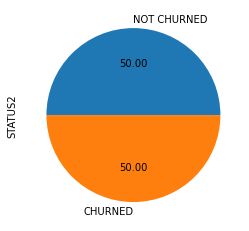

In [ ]:
df['STATUS2'].value_counts().plot.pie(autopct = '%.2f')

In [ ]:
df['STATUS2'] = df['STATUS2'].map({'CHURNED': 1, 'NOT CHURNED': 0})

In [ ]:
df['STATUS2'].value_counts()

0    500000
1    500000
Name: STATUS2, dtype: int64

# **3. Binning of continuous features**
---
Since most of the data that I will be working with is continuous, I will bin them into several smaller categories using two different methods of binning.

1. The first method will be **Equal - Width Binning.**

-> Let's create equal width binning:

In [ ]:
# def binning(df, column_list, method = 'equal_width'):

#   binned_df = df.copy()

#   for col in column_list:
#     if method == 'equal_width':
#       n_bins = int(np.ceil(1 + np.log2(len(binned_df[col]))))
#       bin_width = (binned_df[col].max() - binned_df[col].min()) / n_bins
#       bins = np.arrange(binned_df[col].min(), binned_df[col].max() + bin_width, binwidth)
#       binned_df[col] = pd.cut(binned_df[col], bins = bins, include_lowest = True)

#     elif method == 'freedman_diaconis':
#       iqr = np.subtract(*np.percentile(binned_df[col], [75, 25]))
#       bin_width = 2 * iqr / np.power(len(binned_df[col]), 1/3)
#       bins = np.arrange(binned_df[col].min(), binned_df[col].max() + bin_width, bin_width)
#       binned_df[col = pd.cut(binned_df[col], bins = bins, include_lowest = True)]

#     else:
#       raise ValueError(f"Invalid method: {method}")

#   return binned_df

2. The second method will be **Equal - Frequency Binning.**

# **4. Exploratory Data Analysis**
---
Within our dataset we have several features, some of them being binary categorical features, and continuous features.

Let's first view the correlation:

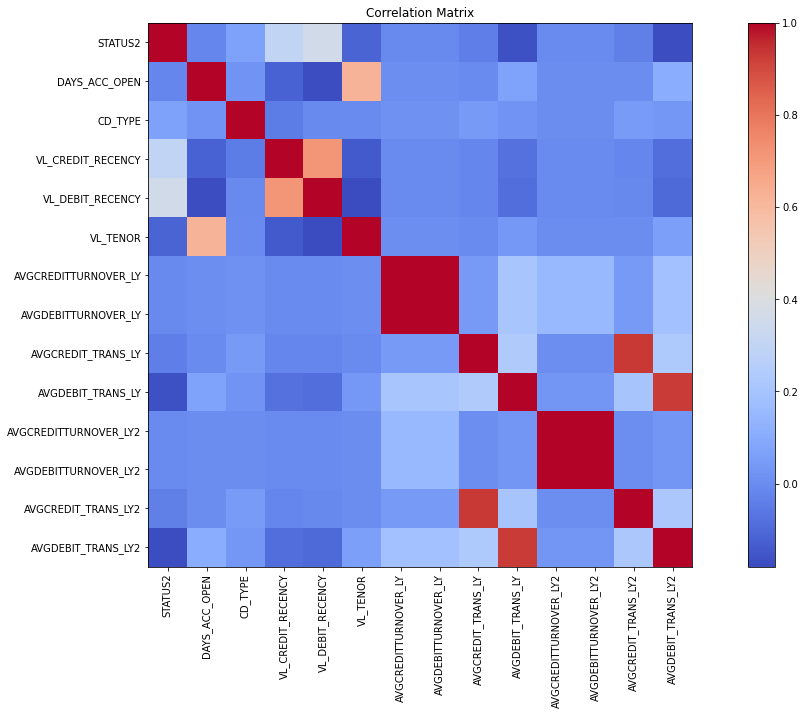

In [ ]:
corr = df.corr()

plt.figure(figsize = (20, 10))
plt.imshow(corr, cmap = 'coolwarm', interpolation = 'none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation = 90)
plt.yticks(range(len(corr)), corr.columns)
plt.title('Correlation Matrix')
plt.show()

1. Binary Categorical Features

Let's explore the binary features:

In [ ]:
df['STATUS2'].value_counts()

0    500000
1    500000
Name: STATUS2, dtype: int64

The target variable does not have an imbalanced class distribution.

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='CD_TYPE', ylabel='count'>

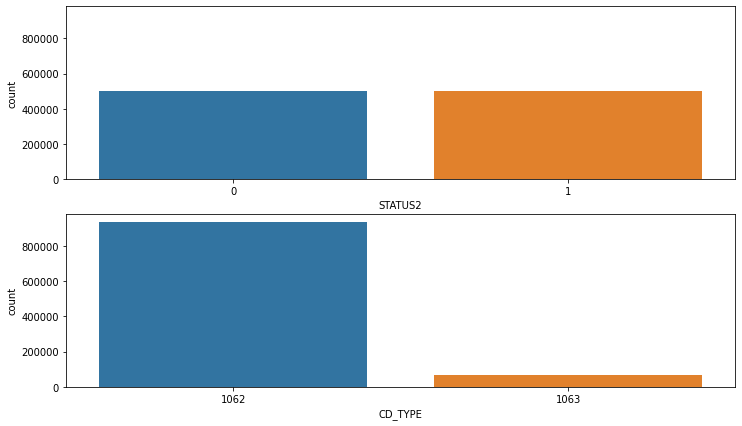

In [ ]:
fig, axes = plt.subplots(2, figsize = (12, 7), sharey = True)

sns.countplot("STATUS2", data = df, ax = axes[0])
sns.countplot("CD_TYPE", data = df, ax = axes[1])

There is a high imbalance in **CD_TYPE** variable. Most of the customers are within the **1062 CD_TYPE**.

It is better to check how the target variable changes according to binary features.

Let's see if the churn rate is different for binary categorical features.

In [ ]:
df[['CD_TYPE', 'STATUS2']].groupby(['CD_TYPE']).mean()

,STATUS2
CD_TYPE,
1062,0.491252
1063,0.623707


Average churn rate for 1063 is higher than that of 1062 which indicates the CD_TYPE variable brings a valuable prediction power to a model.

2. Continuous Features

Time to explore the continuous features.

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

<AxesSubplot:xlabel='AVGDEBIT_TRANS_LY2', ylabel='Density'>

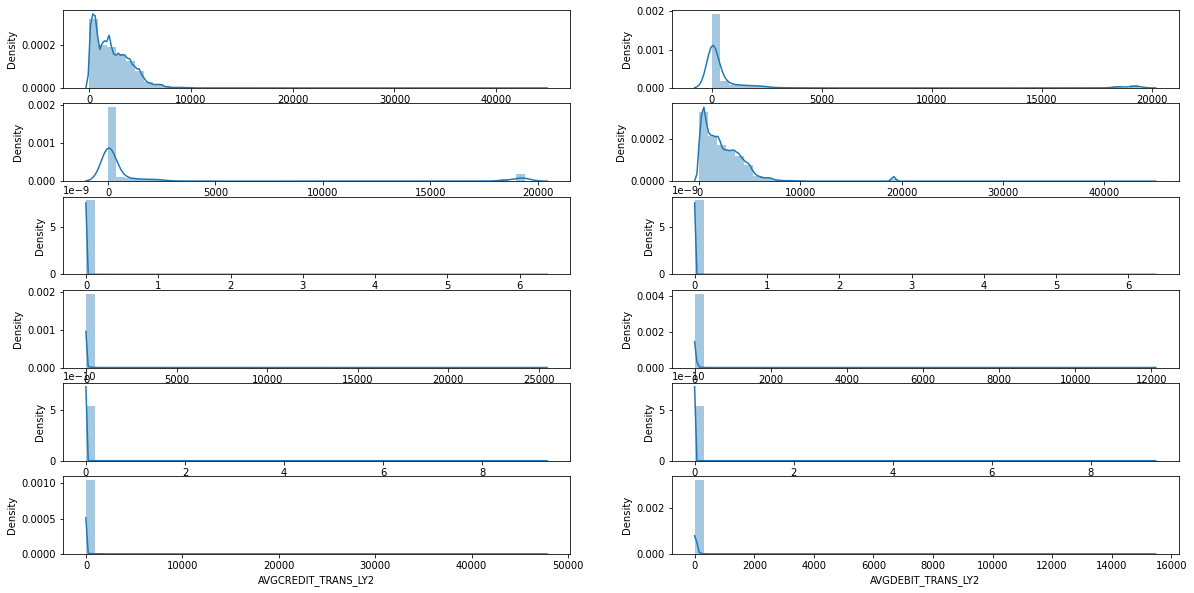

In [ ]:
fig, axes = plt.subplots(6, 2, figsize = (20, 10))

sns.distplot(df["DAYS_ACC_OPEN"], ax = axes[0, 0])
sns.distplot(df["VL_CREDIT_RECENCY"], ax = axes[0, 1])
sns.distplot(df["VL_DEBIT_RECENCY"], ax = axes[1, 0])
sns.distplot(df["VL_TENOR"], ax = axes[1, 1])
sns.distplot(df["AVGCREDITTURNOVER_LY"], ax = axes[2, 0])
sns.distplot(df["AVGDEBITTURNOVER_LY"], ax = axes[2, 1])
sns.distplot(df["AVGCREDIT_TRANS_LY"], ax = axes[3, 0])
sns.distplot(df["AVGDEBIT_TRANS_LY"], ax = axes[3, 1])
sns.distplot(df["AVGCREDITTURNOVER_LY2"], ax = axes[4, 0])
sns.distplot(df["AVGDEBITTURNOVER_LY2"], ax = axes[4, 1])
sns.distplot(df["AVGCREDIT_TRANS_LY2"], ax = axes[5, 0])
sns.distplot(df["AVGDEBIT_TRANS_LY2"], ax = axes[5, 1])

In [ ]:
display(df[['DAYS_ACC_OPEN', 'STATUS2']].groupby('STATUS2').mean(),
        df[['VL_CREDIT_RECENCY', 'STATUS2']].groupby('STATUS2').mean(),
        df[['VL_DEBIT_RECENCY', 'STATUS2']].groupby('STATUS2').mean(),
        df[['VL_TENOR', 'STATUS2']].groupby('STATUS2').mean(),
        df[['AVGCREDITTURNOVER_LY', 'STATUS2']].groupby('STATUS2').mean(),
        df[['AVGDEBITTURNOVER_LY', 'STATUS2']].groupby('STATUS2').mean(),
        df[['AVGCREDIT_TRANS_LY', 'STATUS2']].groupby('STATUS2').mean(),
        df[['AVGDEBIT_TRANS_LY', 'STATUS2']].groupby('STATUS2').mean(),
        df[['AVGCREDITTURNOVER_LY2', 'STATUS2']].groupby('STATUS2').mean(),
        df[['AVGDEBITTURNOVER_LY2', 'STATUS2']].groupby('STATUS2').mean(),
        df[['AVGCREDIT_TRANS_LY2', 'STATUS2']].groupby('STATUS2').mean(),
        df[['AVGDEBIT_TRANS_LY2', 'STATUS2']].groupby('STATUS2').mean())

,DAYS_ACC_OPEN
STATUS2,
0,2312.822070
1,2255.334134


,VL_CREDIT_RECENCY
STATUS2,
0,9.313012
1,2497.785568


,VL_DEBIT_RECENCY
STATUS2,
0,3.683808
1,3956.055128


,VL_TENOR
STATUS2,
0,2657.664280
1,2108.227886


,AVGCREDITTURNOVER_LY
STATUS2,
0,113402.470584
1,10586.195954


,AVGDEBITTURNOVER_LY
STATUS2,
0,114379.669191
1,11216.108808


,AVGCREDIT_TRANS_LY
STATUS2,
0,4.440382
1,0.498808


,AVGDEBIT_TRANS_LY
STATUS2,
0,7.499620
1,1.686956


,AVGCREDITTURNOVER_LY2
STATUS2,
0,389808.402130
1,25230.566049


,AVGDEBITTURNOVER_LY2
STATUS2,
0,390810.959032
1,26448.893283


,AVGCREDIT_TRANS_LY2
STATUS2,
0,7.851147
1,1.393216


,AVGDEBIT_TRANS_LY2
STATUS2,
0,13.844847
1,3.822426


# **5. Variable Selection**
---

In [ ]:
df.drop(['CD_ACCOUNT'], axis = 1, inplace = True)

df.shape

(1000000, 14)

In [ ]:
print(df.dtypes)

STATUS2                    int64
DAYS_ACC_OPEN              int64
CD_TYPE                    int64
VL_CREDIT_RECENCY        float64
VL_DEBIT_RECENCY         float64
VL_TENOR                 float64
AVGCREDITTURNOVER_LY     float64
AVGDEBITTURNOVER_LY      float64
AVGCREDIT_TRANS_LY       float64
AVGDEBIT_TRANS_LY        float64
AVGCREDITTURNOVER_LY2    float64
AVGDEBITTURNOVER_LY2     float64
AVGCREDIT_TRANS_LY2      float64
AVGDEBIT_TRANS_LY2       float64
dtype: object


In [ ]:
df.head()

,STATUS2,DAYS_ACC_OPEN,CD_TYPE,VL_CREDIT_RECENCY,VL_DEBIT_RECENCY,VL_TENOR,AVGCREDITTURNOVER_LY,AVGDEBITTURNOVER_LY,AVGCREDIT_TRANS_LY,AVGDEBIT_TRANS_LY,AVGCREDITTURNOVER_LY2,AVGDEBITTURNOVER_LY2,AVGCREDIT_TRANS_LY2,AVGDEBIT_TRANS_LY2
0,0,6173,1062,21.0,0.0,6170.0,438197.26,474788.26,3.08,93.66,720779.28,748023.72,6.33,133.41
1,1,6163,1062,313.0,0.0,6118.0,1666.66,6590.41,0.16,1.25,1666.66,9322.83,0.16,3.08
2,1,6152,1062,2126.0,1949.0,6132.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,1,6124,1062,982.0,0.0,5770.0,0.00,1220.00,0.00,0.41,0.00,2102.00,0.00,0.91
4,0,6117,1062,0.0,0.0,6091.0,4126.41,200.50,1.08,3.66,7935.41,395.00,2.08,7.50


# **6. Model Creation and Evaluation**
---

In [ ]:
cat_features = ['CD_TYPE']

X = pd.get_dummies(df, columns = cat_features, drop_first = True)

In [ ]:
sc = MinMaxScaler()
a = sc.fit_transform(df[['DAYS_ACC_OPEN']])
b = sc.fit_transform(df[['VL_CREDIT_RECENCY']])
c = sc.fit_transform(df[['VL_DEBIT_RECENCY']])
d = sc.fit_transform(df[['VL_TENOR']])
e = sc.fit_transform(df[['AVGCREDITTURNOVER_LY']])
f = sc.fit_transform(df[['AVGDEBITTURNOVER_LY']])
g = sc.fit_transform(df[['AVGCREDIT_TRANS_LY']])
h = sc.fit_transform(df[['AVGDEBIT_TRANS_LY']])
i = sc.fit_transform(df[['AVGCREDITTURNOVER_LY2']])
j = sc.fit_transform(df[['AVGDEBITTURNOVER_LY2']])
k = sc.fit_transform(df[['AVGCREDIT_TRANS_LY2']])
l = sc.fit_transform(df[['AVGDEBIT_TRANS_LY2']])

X['DAYS_ACC_OPEN'] = a
X['VL_CREDIT RECENCY'] = b
X['VL_DEBIT_RECENCY'] = c
X['VL_TENOR'] = d
X['AVGCREDITTURNOVER_LY'] = e
X['AVGDEBITTURNOVER_LY'] = f
X['AVGCREDIT_TRANS_LY'] = g
X['AVGDEBIT_TRANS_LY'] = h
X['AVGCREDITTURNOVER_LY2'] = i
X['AVGDEBITTURNOVER_LY2'] = j
X['AVGDEBITTURNOVER_LY2'] = k
X['AVGDEBIT_TRANS_LY2'] = l

In [ ]:
X.shape

(1000000, 15)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Class Distribution')

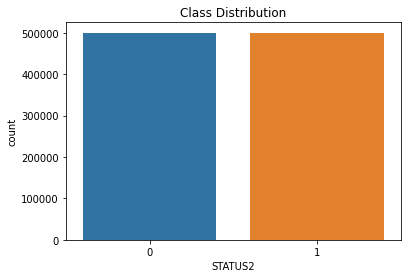

In [ ]:
sns.countplot('STATUS2', data = df).set_title('Class Distribution')

In [ ]:
X_no = X[X.STATUS2 == 0]
X_yes = X[X.STATUS2 == 1]

In [ ]:
X_yes_upsampled = X_yes.sample(n = len(X_no), replace = True, random_state = 42)

print(len(X_yes_upsampled))

500000


In [ ]:
X_upsampled = X_no.append(X_yes_upsampled).reset_index(drop = True)

sns.countplot('STATUS2', data = X_upsampled).set_title('Class Distribution')

In [ ]:
df['STATUS2'].value_counts()

In [ ]:
X = X_upsampled.drop(['STATUS2'], axis = 1)
y = X_upsampled['STATUS2']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
print(df.dtypes)

In [ ]:
clf_ridge = RidgeClassifier()
clf_ridge.fit(X_train, y_train)

In [ ]:
pred = clf_ridge.predict(X_train)

accuracy_score(y_train, pred)

In [ ]:
pred_test = clf_ridge.predict(X_test)

accuracy_score(y_test, pred_test)

In [ ]:
clf_forest = RandomForestClassifier(n_estimators = 100, max_depth = 10)
clf_forest.fit(X_train, y_train)

In [ ]:
pred = clf_forest.predict(X_train)

accuracy_score(y_train, pred)

In [ ]:
pred_test = clf_forest.predict(X_test)

accuracy_score(y_test, pred_test)

# **7. Improve the model**
---

In [ ]:
parameters = {
    'n_estimators': [50, 100, 200, 250], 'max_depth': [5, 10, 25, 30]
}

forest = RandomForestClassifier()

clf = GridSearchCV(estimator = forest, param_grid = parameters, n_jobs = -1, cv = 5)

In [ ]:
clf.fit(X, y)

In [ ]:
clf.best_params_

In [ ]:
clf.best_score_